# Introduction
Many people are lured to the life in a big city. The promises of a city that never sleeps, with more nationalities than you can count, and the possibities to eat food from every region in the world is a massive attraction. But.. What is the difference really, between a city like Amsterdam and one like New York? Is there really such a huge difference ? For this exercise we'll explore the culinary options in both cities to figure out if making the jump overseas will make a foodies heart jump with joy. We will dive into the neighbourhoods to figure out how many different kitchens we can find and how many of them there are.



# Data
We will be using the Foursquare API to get information about the venues. Using the Places API and the "explore" call we can get a list of venues around a specific location (the center of a neighbourhood in this case). For New York we will rely on the "newyork_data.json" data file which contains the boroughs, the neighbourhoods and their location. For Amsterdam, we will use the data from https://maps.amsterdam.nl/open_geodata/ to find the names and postal codes of all the neighbourhoods. We'll grab the location data from the Geocoder Python package

In [40]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3
import io
import numpy as np

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # needed for waffle Charts

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

!pip install folium
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
print('Libraries imported')

Matplotlib version:  3.2.2
Libraries imported


In [13]:
# cell below is hidden to protect credentials. It reads an Excel file containing the Amsterdam boroughs with their location contfrom the IBM storage

In [14]:
# The code was removed by Watson Studio for sharing.

In [16]:

body = client_3a0ef4c344124746a61e93ed7750c729.get_object(Bucket='courseradatasciencecapstoneprojec-donotdelete-pr-vavfhljeds8ejj',Key='GEBIED_BUURTEN.xlsx')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )


#parse the Excel data
amsterdam_data = pd.read_excel(io.BytesIO(body.read()))


# remove first header row
amsterdam_data.columns = amsterdam_data.iloc[0]
amsterdam_data = amsterdam_data.reindex(amsterdam_data.index.drop(0)).reset_index(drop=True)
amsterdam_data.columns.name = None

# drop obsolete columns
amsterdam_data.drop(columns=['OBJECTNUMMER','Buurt_code','Buurtcombinatie_code','Opp_m2','WKT_LNG_LAT', 'WKT_LAT_LNG'],inplace=True)

# rename from Dutch to international terms
amsterdam_data.rename(columns={"Buurt": "Neighbourhood"},inplace=True)
amsterdam_data.rename(columns={"Stadsdeel_code": "Borough"},inplace=True)


# rename for better readability
amsterdam_data.rename(columns={"LAT": "Latitude"},inplace=True)
amsterdam_data.rename(columns={"LNG": "Longitude"},inplace=True)

# focus on center of Amsterdam
amsterdam_data = amsterdam_data[np.isin(amsterdam_data['Borough'], ['A'])]

amsterdam_data.head()
#amsterdam_data.shape


,Neighbourhood,Borough,Longitude,Latitude,NaN
36,Kop Zeedijk,A,4.9001715,52.3757235,NaN
37,BG-terrein e.o.,A,4.89557815,52.369559,NaN
38,Stationsplein e.o.,A,4.9009435,52.3797652,NaN
39,Hemelrijk,A,4.8949027,52.37821835,NaN
40,Spuistraat Noord,A,4.8915324,52.37508835,NaN


In [17]:
address = 'Amsterdam, Netherlands'

geolocator = Nominatim(user_agent="ams_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Amsterdam are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Amsterdam are 52.3727598, 4.8936041.


In [18]:
# create map of New York using latitude and longitude values
map_amsterdam = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighbourhood in zip(amsterdam_data['Latitude'], amsterdam_data['Longitude'], amsterdam_data['Borough'], amsterdam_data['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_amsterdam)  
    
map_amsterdam

In [19]:
# The code was removed by Watson Studio for sharing.

In [20]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [21]:
# helper function to parse the results from an exploration of a list of locations
def getNearbyVenues(names, latitudes, longitudes, radius=radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
amsterdam_venues = getNearbyVenues(names=amsterdam_data['Neighbourhood'],
                                   latitudes=amsterdam_data['Latitude'],
                                   longitudes=amsterdam_data['Longitude']
                                  )
amsterdam_venues.head()

Kop Zeedijk
BG-terrein e.o.
Stationsplein e.o.
Hemelrijk
Spuistraat Noord
Nieuwe Kerk e.o.
Spuistraat Zuid
Kalverdriehoek
Langestraat e.o.
Leliegracht e.o.
Felix Meritisbuurt
Leidsegracht Noord
Spiegelbuurt
Gouden Bocht
Van Loonbuurt
Amstelveldbuurt
Rembrandtpleinbuurt
Scheepvaarthuisbuurt
Rapenburg
Lastage
Uilenburg
Valkenburg
Zuiderkerkbuurt
Waterloopleinbuurt
Haarlemmerbuurt West
Westelijke eilanden
Driehoekbuurt
Bloemgrachtbuurt
Marnixbuurt Noord
Marnixbuurt Midden
Elandsgrachtbuurt
Passeerdersgrachtbuurt
Groenmarktkadebuurt
Marnixbuurt Zuid
Leidsebuurt Noordwest
Leidsebuurt Zuidwest
Leidsebuurt Noordoost
Leidsebuurt Zuidoost
Weteringbuurt
Den Texbuurt
Utrechtsebuurt Zuid
Frederikspleinbuurt
Weesperbuurt
Sarphatistrook
Kattenburg
Wittenburg
Nieuwendijk Noord
Zaagpoortbuurt
Planciusbuurt Noord
Planciusbuurt Zuid
Anjeliersbuurt Noord
Anjeliersbuurt Zuid
Leidsegracht Zuid
Reguliersbuurt
Plantage
Alexanderplein e.o.
Kadijken
Oude Kerk e.o.
Burgwallen Oost
Nes e.o.
Begijnhofbuurt
Ooster

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Kop Zeedijk,52.3757235,4.9001715,De Koffieschenkerij,52.374043,4.898427,Coffee Shop
1,Kop Zeedijk,52.3757235,4.9001715,Omelegg - City Centre,52.376060,4.899802,Breakfast Spot
2,Kop Zeedijk,52.3757235,4.9001715,Café 't Mandje,52.374844,4.900878,Gay Bar
3,Kop Zeedijk,52.3757235,4.9001715,Red Light Radio,52.374626,4.897840,Music Venue
4,Kop Zeedijk,52.3757235,4.9001715,OCHA,52.374024,4.901683,Thai Restaurant


In [23]:
# check the list of venues per neighbourhood
amsterdam_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Alexanderplein e.o.,100,100,100,100,100,100
Amstelveldbuurt,100,100,100,100,100,100
Anjeliersbuurt Noord,100,100,100,100,100,100
Anjeliersbuurt Zuid,100,100,100,100,100,100
BG-terrein e.o.,100,100,100,100,100,100
...,...,...,...,...,...,...
Westerdokseiland,100,100,100,100,100,100
Weteringbuurt,100,100,100,100,100,100
Wittenburg,100,100,100,100,100,100


In [24]:
# find out how many unique categories we have
print('There are {} uniques categories.'.format(len(amsterdam_venues['Venue Category'].unique())))

There are 159 uniques categories.


In [25]:
#amsterdam_venues = amsterdam_venues.drop(amsterdam_venues[amsterdam_venues['Venue Category'].isin(['Hotel','Train Station'])].index)


amsterdam_venues = amsterdam_venues[np.isin(amsterdam_venues['Venue Category'], ['Hotel','Train Station'], invert=True)]

In [26]:
# find out how many unique categories we have
print('There are {} uniques categories.'.format(len(amsterdam_venues['Venue Category'].unique())))

There are 157 uniques categories.


In [27]:
# one hot encoding to do analysis on categorical variables
amsterdam_onehot = pd.get_dummies(amsterdam_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
amsterdam_onehot['Neighbourhood'] = amsterdam_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [amsterdam_onehot.columns[-1]] + list(amsterdam_onehot.columns[:-1])
amsterdam_onehot = amsterdam_onehot[fixed_columns]

amsterdam_onehot.head()

,Neighbourhood,Accessories Store,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,BBQ Joint,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Windmill,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Kop Zeedijk,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Kop Zeedijk,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Kop Zeedijk,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Kop Zeedijk,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Kop Zeedijk,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# group by neighbourhood
amsterdam_grouped = amsterdam_onehot.groupby('Neighbourhood').mean().reset_index()
amsterdam_grouped

,Neighbourhood,Accessories Store,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,BBQ Joint,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Windmill,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Alexanderplein e.o.,0.0,0.010870,0.0,0.000000,0.010870,0.000000,0.000000,0.021739,0.000000,...,0.010870,0.000000,0.000000,0.010870,0.010870,0.000000,0.000000,0.021739,0.010870,0.021739
1,Amstelveldbuurt,0.0,0.000000,0.0,0.000000,0.021505,0.021505,0.000000,0.000000,0.000000,...,0.021505,0.021505,0.010753,0.000000,0.010753,0.010753,0.010753,0.021505,0.010753,0.000000
2,Anjeliersbuurt Noord,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.011364,...,0.000000,0.000000,0.000000,0.000000,0.011364,0.000000,0.000000,0.034091,0.000000,0.000000
3,Anjeliersbuurt Zuid,0.0,0.000000,0.0,0.000000,0.011111,0.000000,0.000000,0.000000,0.011111,...,0.000000,0.000000,0.000000,0.000000,0.011111,0.000000,0.011111,0.033333,0.000000,0.000000
4,BG-terrein e.o.,0.0,0.000000,0.0,0.000000,0.034483,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.011494,0.000000,0.000000,0.000000,0.011494,0.011494,0.022989,0.011494,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Westerdokseiland,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.011494,...,0.011494,0.000000,0.000000,0.000000,0.011494,0.000000,0.000000,0.011494,0.000000,0.000000
66,Weteringbuurt,0.0,0.000000,0.0,0.000000,0.053763,0.021505,0.000000,0.000000,0.000000,...,0.021505,0.021505,0.010753,0.000000,0.010753,0.010753,0.010753,0.021505,0.000000,0.000000
67,Wittenburg,0.0,0.010989,0.0,0.000000,0.010989,0.000000,0.010989,0.010989,0.000000,...,0.000000,0.000000,0.000000,0.010989,0.010989,0.000000,0.000000,0.021978,0.010989,0.010989
68,Zaagpoortbuurt,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.010870,...,0.000000,0.000000,0.000000,0.000000,0.010870,0.000000,0.010870,0.032609,0.000000,0.000000


In [29]:
# print top 5 list of venues for every neighbourhood
num_top_venues = 5

for hood in amsterdam_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = amsterdam_grouped[amsterdam_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alexanderplein e.o.----
                venue  freq
0                 Bar  0.08
1          Restaurant  0.05
2   French Restaurant  0.04
3      Breakfast Spot  0.04
4  Italian Restaurant  0.03


----Amstelveldbuurt----
               venue  freq
0     Breakfast Spot  0.06
1        Coffee Shop  0.05
2         Restaurant  0.04
3  French Restaurant  0.04
4             Bakery  0.03


----Anjeliersbuurt Noord----
            venue  freq
0     Coffee Shop  0.08
1             Bar  0.06
2  Chocolate Shop  0.05
3          Bakery  0.05
4     Yoga Studio  0.03


----Anjeliersbuurt Zuid----
            venue  freq
0             Bar  0.07
1     Coffee Shop  0.07
2          Bakery  0.04
3  Breakfast Spot  0.03
4      Restaurant  0.03


----BG-terrein e.o.----
            venue  freq
0     Coffee Shop  0.06
1  Breakfast Spot  0.06
2    Cocktail Bar  0.03
3      Art Museum  0.03
4      Restaurant  0.03


----Begijnhofbuurt----
            venue  freq
0  Sandwich Place  0.04
1       Bookstore  0.03


In [30]:
# install wordcloud
!pip install wordcloud

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

Wordcloud is installed and imported!


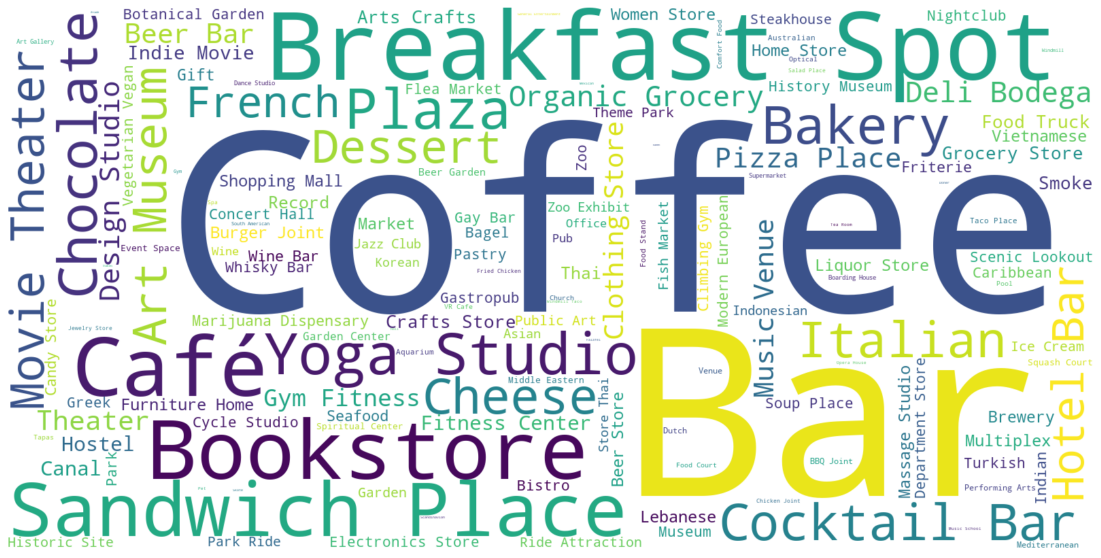

In [44]:
# instantiate a word cloud object to visualize all the categories
categories_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=['Shop','Restaurant'],
    width=1600,
    height=800
)


words = amsterdam_venues['Venue Category'].str.cat(sep=' ')
#words

# generate the word cloud
categories_wc.generate(words)

# display the word cloud
plt.figure( figsize=(40,10) )
plt.imshow(categories_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

